In [2]:
%load_ext autoreload
%load_ext scalene
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
# Add project root to path - adjust the number of parent dirs (..) based on where your notebook is located
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.visualization as vis
import src.utils as utils
from src.utils import PacmanDataReader
import src.analysis as analysis

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


LOADING
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version. To profile in line mode, use
`%scrun [options] statement`. To profile in cell mode, use `%%scalene
[options]` followed by your code.


In [3]:
data = PacmanDataReader(data_folder='../data/', read_games_only=True)


Observations regarding trajectories, most of them can be seen in the example below:
- Trajectories don't necessarily start at the same time or position (even though they should). 
- Trajectories don't necessarily have the same length.
- Sampling time is not consistent. It should be every 50 ms, but sometimes it's shorter or longer. However, weirdly the timing between two consecutive samples is consistent (100 ms) (i.e, if one sample has a dt of 0.03 s, the next one will have a dt of 0.07 s).
- Velocities are not the same, they vary between levels (i.e, level 2 is faster than level 1).


In [5]:
### Inspecting raw values of velocity and time
ts1 = data.get_trajectory_dataframe(game_id=993).reset_index(drop=True) # game 993 is played on level 4

ts1['dx'], ts1['dy'] = utils.calculate_velocities(np.array(ts1[['Pacman_X', 'Pacman_Y']]), round=False)

ts1['dt'] = np.diff(ts1['time_elapsed'], prepend=ts1['time_elapsed'].iloc[0])

ts1['dx'] = ts1['dx'] / ts1['dt']
ts1['dy'] = ts1['dy'] / ts1['dt']

ts2 = data.get_trajectory_dataframe(game_id=990).reset_index(drop=True) # game 990 is played on level 1

ts2['dx'], ts2['dy'] = utils.calculate_velocities(np.array(ts2[['Pacman_X', 'Pacman_Y']]), round=False)

ts2['dt'] = np.diff(ts2['time_elapsed'], prepend=ts2['time_elapsed'].iloc[0])
ts2['dx'] = ts2['dx'] / ts2['dt']
ts2['dy'] = ts2['dy'] / ts2['dt']


ds = pd.concat([ts1, ts2], axis=1).reset_index(drop=True)
ds

,game_id,time_elapsed,Pacman_X,Pacman_Y,dx,dy,dt,game_id,time_elapsed,Pacman_X,Pacman_Y,dx,dy,dt
0,993.0,0.18,1.534140,-9.326811,NaN,NaN,0.00,990,0.200000,1.485321,-9.489613,NaN,NaN,0.000000
1,993.0,0.23,1.476429,-9.005260,-1.154215,6.431008,0.05,990,0.250000,1.788361,-9.489613,6.060801,0.000000,0.050000
2,993.0,0.28,1.499031,-8.494056,0.452032,10.224095,0.05,990,0.300000,2.240156,-9.503768,9.035907,-0.283108,0.050000
3,993.0,0.33,1.499931,-8.153136,0.018005,6.818388,0.05,990,0.350000,2.543196,-9.501216,6.060803,0.051041,0.050000
4,993.0,0.38,1.500392,-7.641757,0.009217,10.227588,0.05,990,0.390000,2.997756,-9.499909,11.364003,0.032663,0.040000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990,56.139999,10.500672,-10.714727,-0.011095,15.041137,0.029999
1120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990,56.209999,10.500604,-10.411688,-0.000981,4.329155,0.070000
1121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990,56.240002,10.500568,-9.957129,-0.001176,15.150668,0.030003
1122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,990,56.310001,10.502164,-9.654089,0.022793,4.329155,0.070000


## Similarity Measures

Next we replicate the different similarity measures that can be used to calculate distance between trajectories. This calculations can be used for classifying or clustering the set of trajectories.



In [6]:
data.game_df.shape

(855, 10)

In [7]:
viz = vis.GameVisualizer(data_folder="../data/")

# games = data.game_df.sample(600)['game_id'].to_list()
games = data.game_df['game_id'].to_list()
subtraj_lists = []

for game in games:
    sub_traj = data.get_partial_trajectory_array(game_id=game, end_timestep= 50)
    subtraj_lists.append(sub_traj)

# viz.plot_multiple_trajectories(trajectories=subtraj_lists, plot_type="line")


The `analysis.SimilarityMeasures` class includes the several measures described by [Tao et al. (2021)](https://doi.org/10.1080/15481603.2021.1908927). These measures are used to calculate a distance matrix and cluster based on a distance metric specific to trajectory analysis.
The similarity measures are:
- Lock-step Euclidean Distance (and the manhattan variation)
- Dynamic Time Warping (DTW)
- Edit Distance (EDR)
- Longest Common Subsequence (LCSS)
- Discrete Fréchet Distance (DFD)
- Fréchet Distance (DF)

In [8]:
sim_measures = analysis.SimilarityMeasures(measure_type='euclidean')

sim_measures.calculate_distance(subtraj_lists[0],subtraj_lists[1])

np.float64(764.2167110857166)

In [34]:
GeomClustering = analysis.GeomClustering(similarity_measure='euclidean')
distance_matrix = GeomClustering.calculate_distance_matrix(subtraj_lists)
distance_matrix
distance_matrix.mean()
distance_matrix.max()
distance_matrix.min()

distance_matrix.size

INFO - src.analysis.geom_clustering - Initializing GeomClustering with similarity measure: euclidean


array([[  0.        , 764.21671109, 456.85255228, ...,  73.43945604,
        603.40882945, 226.56856565],
       [764.21671109,   0.        , 420.64886468, ..., 794.2748217 ,
        216.34364772, 657.72599496],
       [456.85255228, 420.64886468,   0.        , ..., 466.26081834,
        227.48128216, 499.69899908],
       ...,
       [ 73.43945604, 794.2748217 , 466.26081834, ...,   0.        ,
        626.70816776, 295.38353092],
       [603.40882945, 216.34364772, 227.48128216, ..., 626.70816776,
          0.        , 552.37763849],
       [226.56856565, 657.72599496, 499.69899908, ..., 295.38353092,
        552.37763849,   0.        ]])

np.float64(398.59578966789655)

np.float64(942.6773084395899)

np.float64(0.0)

731025

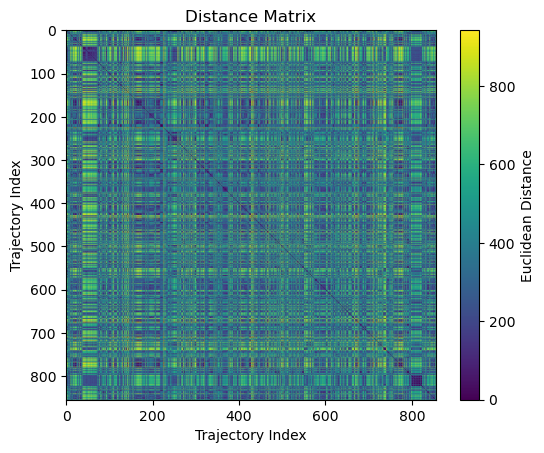

In [35]:

GeomClustering.plot_distance_matrix()

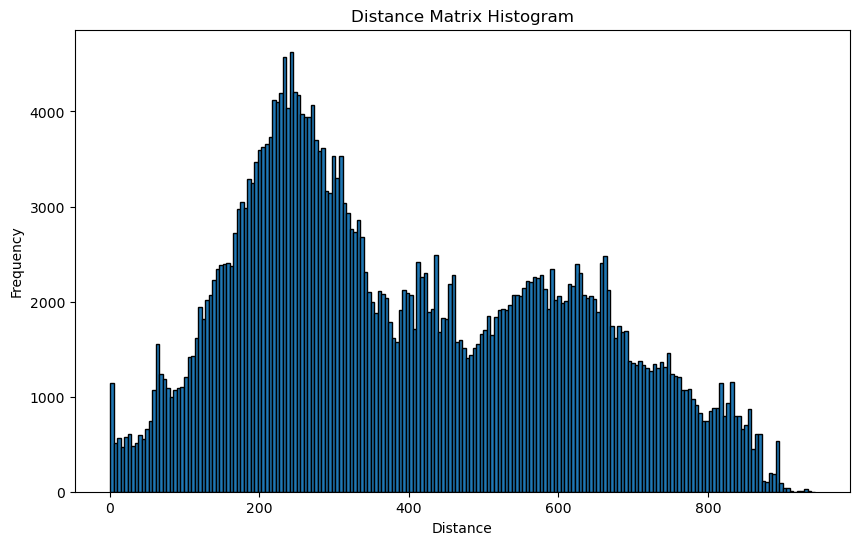

In [36]:
GeomClustering.plot_distance_matrix_histogram()

### Clustering



In [37]:
# labels = GeomClustering.cluster_trajectories() ## if distances already calculated

labels = GeomClustering.fit(subtraj_lists)

INFO - src.analysis.geom_clustering - Fitting clustering model with 855 trajectories
INFO - src.analysis.geom_clustering - Clustering complete. Found 9 clusters


In [38]:
subtraj_lists.__len__()
labels.__len__()

855

855

In [39]:
labels_series = pd.Series(labels)
labels_series.unique()
labels_series.value_counts()


array([-1,  1,  2,  0,  5,  4,  3,  7,  6])

-1    778
 0     20
 1     16
 2      9
 3      8
 4      7
 5      6
 6      6
 7      5
Name: count, dtype: int64

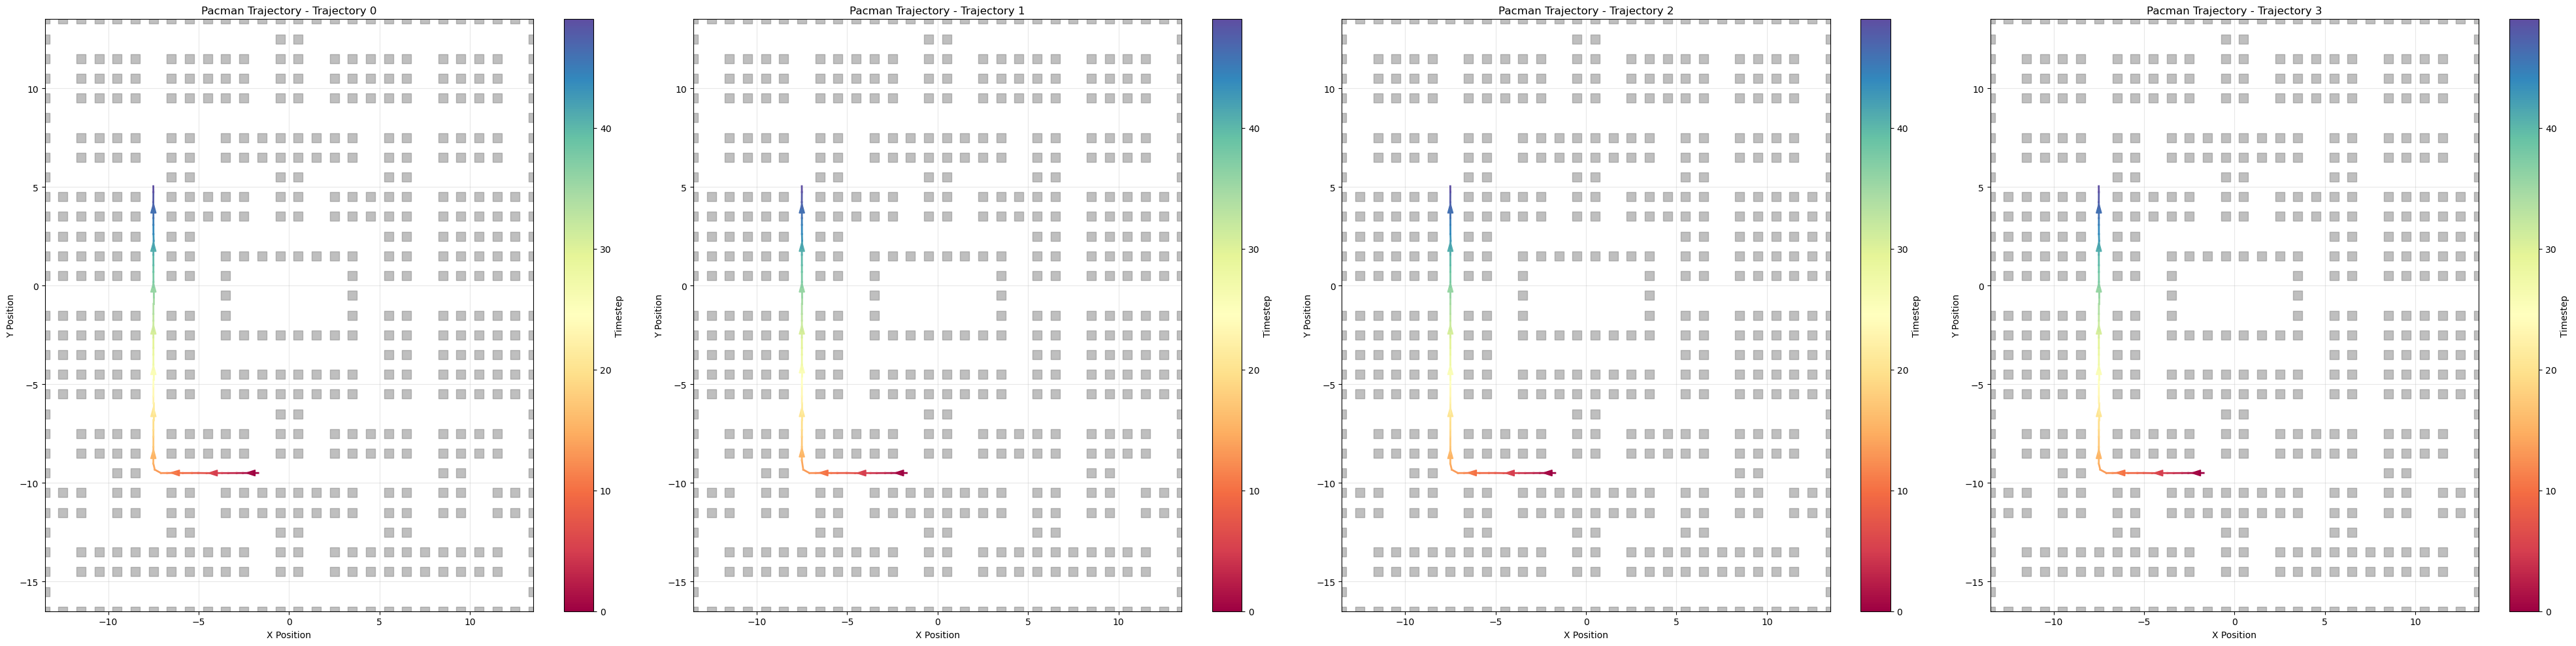

In [66]:
cluster_1 = pd.Series(subtraj_lists)[labels == 1]

subset = cluster_1.sample(4).tolist()
viz = vis.GameVisualizer(figsize=[10,10])
viz.plot_multiple_trajectories(trajectories=subset,plot_type='line')

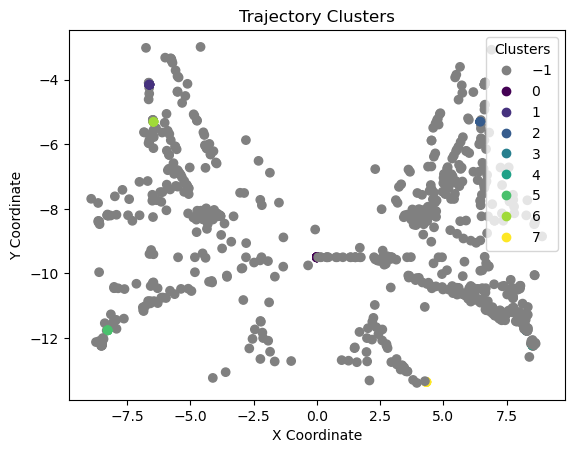

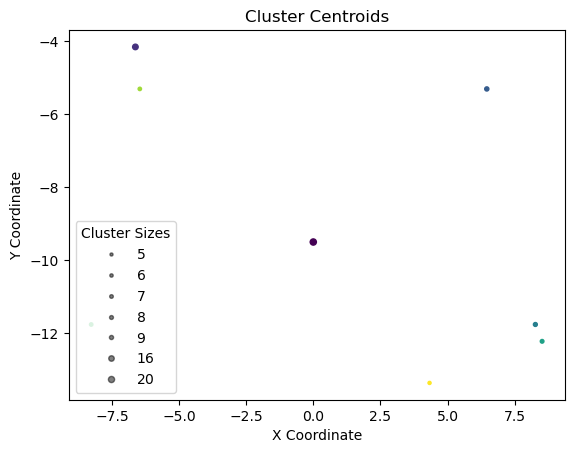

In [65]:
GeomClustering.plot_trajectories()
GeomClustering.plot_cluster_centroids()

In [59]:
np.unique(GeomClustering.labels)
GeomClustering._calculate_cluster_centroids().shape

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

(8, 2)